In [1]:
import pandas as pd
import numpy as np
import os

# data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing text
import nltk
import re
import ssl 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# train test split
from sklearn.model_selection import train_test_split

# feature engineering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold

# modelling
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

/Users/szeyinglim/Desktop/BT4012/Fraud-Email/.venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


## Reading Data

In [2]:
df = pd.read_csv("./data/Phish_No_More.csv")
df.shape

(39154, 7)

In [3]:
SEED = 42

In [4]:
df.head()

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


## Cleaning the Data

In [5]:
# Splitting 'sender' into 'name' and 'email'
df[['sender_name', 'sender_email']] = df['sender'].str.extract(r'(?P<name>.+?)\s*<(?P<email>.+?)>')

# Use the 'str.extract' method to create two new columns based on the pattern
df[['receiver_name', 'receiver_email']] = df['receiver'].str.extract(r'(?:(?P<receiver_name>.*)\s<)?(?P<receiver_email>[^<>]+)>?')

# Extracting the domain from 'sender_email'
df['sender_domain'] = df['sender_email'].str.extract(r'@(.+)', expand=False)

# Extracting the domain from 'receiver_email'
df['receiver_domain'] = df['receiver_email'].str.extract(r'@(.+)', expand=False)


In [6]:
# Converting 'date' to datetime format and forcing invalid formats to NaT
df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)

# Dropping rows where 'date' is NaT (i.e., invalid datetime entries)
df = df.dropna(subset=['date'])

# Extracting year, month, day, hour from the 'date' column
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour

In [7]:
# Renaming 'urls' column to 'body_contains_url'
df.rename(columns={'urls': 'body_contains_url'}, inplace=True)

# Renaming 'label' column to 'is_fraud_email'
df.rename(columns={'label': 'is_fraud_email'}, inplace=True)

In [8]:
# Check for null values in the DataFrame
null_summary = df.isnull().sum()

# Display the columns with null values
print("Columns with null values:\n", null_summary[null_summary > 0])

Columns with null values:
 receiver             462
subject               28
sender_name         3454
sender_email        3454
receiver_name      32048
receiver_email       462
sender_domain       3456
receiver_domain      558
dtype: int64


In [9]:
# Drop rows where 'receiver', 'subject', or 'receiver_email' are null
df = df.dropna(subset=['receiver', 'subject', 'receiver_email'])

# Drop the 'receiver_name' column entirely due to high percentage of missing values
df = df.drop(columns=['receiver_name'])

# Drop rows where both 'sender_name' and 'sender_email' are null
df = df.dropna(subset=['sender_name', 'sender_email'], how='all')

# Optionally, drop rows where 'sender_domain' and 'receiver_domain' are null if domain analysis is important
df = df.dropna(subset=['sender_domain', 'receiver_domain'], how='any')

In [10]:
# Drop the specified columns
df = df.drop(columns=['sender', 'receiver'])

In [11]:
# Final df shape
df.shape

(35286, 14)

In [12]:
df.head()

,date,subject,body,is_fraud_email,body_contains_url,sender_name,sender_email,receiver_email,sender_domain,receiver_domain,year,month,day,hour
0,2008-08-05 23:31:02+00:00,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,Young Esposito,Young@iworld.de,user4@gvc.ceas-challenge.cc,iworld.de,gvc.ceas-challenge.cc,2008,8,5,23
1,2008-08-05 23:31:03+00:00,Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1,Mok,ipline's1983@icable.ph,user2.2@gvc.ceas-challenge.cc,icable.ph,gvc.ceas-challenge.cc,2008,8,5,23
2,2008-08-06 08:28:00+00:00,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,Daily Top 10,Karmandeep-opengevl@universalnet.psi.br,user2.9@gvc.ceas-challenge.cc,universalnet.psi.br,gvc.ceas-challenge.cc,2008,8,6,8
3,2008-08-05 23:31:20+00:00,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,Michael Parker,ivqrnai@pobox.com,xrh@spamassassin.apache.org,pobox.com,spamassassin.apache.org,2008,8,5,23
4,2008-08-05 23:31:21+00:00,SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1,Gretchen Suggs,externalsep1@loanofficertool.com,user2.2@gvc.ceas-challenge.cc,loanofficertool.com,gvc.ceas-challenge.cc,2008,8,5,23


In [13]:
df.isnull().sum()

date                 0
subject              0
body                 0
is_fraud_email       0
body_contains_url    0
sender_name          0
sender_email         0
receiver_email       0
sender_domain        0
receiver_domain      0
year                 0
month                0
day                  0
hour                 0
dtype: int64

## Pre-Preprocessing Data Visualisation

In [14]:
# Get counts of each 'Email Type'
email_type_counts = df["is_fraud_email"].value_counts().reset_index()

# Rename columns for clarity
email_type_counts.columns = ["Email Type", "Count"]

# Calculate total count of emails
total_count = email_type_counts["Count"].sum()

# Calculate percentages and round off to 1 decimal place
email_type_counts["Percentage"] = ((email_type_counts["Count"] / total_count) * 100).round(1)

# Display percentages as numeric with '%' symbol attached
email_type_counts["Percentage"] = email_type_counts["Percentage"].astype(str) + '%'

email_type_counts

,Email Type,Count,Percentage
0,1,20354,57.7%
1,0,14932,42.3%


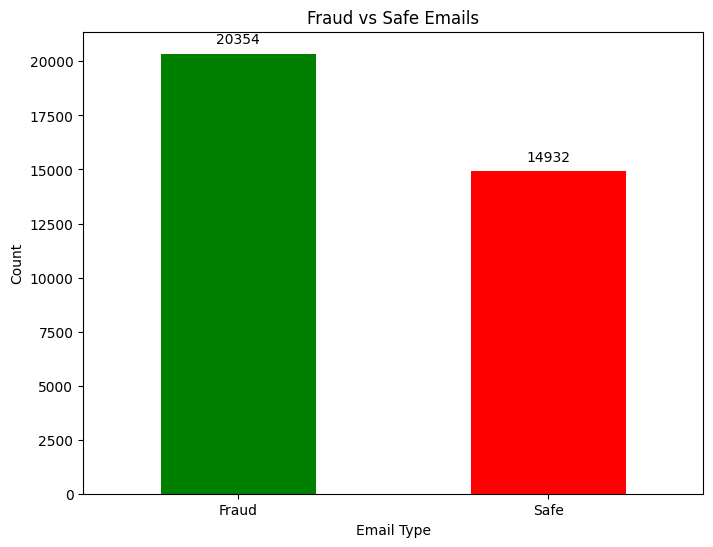

In [15]:
# Count the occurrences of each category in 'is_fraud_email'
fraud_counts = df['is_fraud_email'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
ax = fraud_counts.plot(kind='bar', color=['green', 'red'])

# Adding title and labels
plt.title('Fraud vs Safe Emails')
plt.xlabel('Email Type')
plt.ylabel('Count')

# Add the count values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Show the plot
plt.xticks(ticks=[0, 1], labels=['Fraud', 'Safe'], rotation=0)
plt.show()


## Pre-Processing Email Text

In [16]:
# Download nltk datasets

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/szeyinglim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/szeyinglim/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/szeyinglim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/szeyinglim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Preprocess without lemmatization
Maintains contextual semantics and meaning

In [17]:
def preprocess_text(text: str) -> str:
    # Lowercase the text
    text = str(text).lower()
    
    # Remove punctuation, numbers, and special characters
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize the text
    words = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Join the words back into a single string
    return ' '.join(words)

df['processed_text'] = df['body'].apply(preprocess_text)
df['processed_text']

0        buck troubles caused small dimension soon beco...
1        upgrade sex pleasures techniques httpwwwbright...
2        daily top cnncom top videos stories aug pm edt...
3        would anyone object removing list tld basicall...
4        welcomefastshippingcustomersupport httpiwfnabl...
                               ...                        
39149    cnn alerts custom alert alert name custom aler...
39150    cnn alerts custom alert alert name custom aler...
39151    hello great work slide show viewer application...
39152    mail sender coming intuitcom servers subject t...
39153    dear fellow pythonistas guido accepted user si...
Name: processed_text, Length: 35286, dtype: object

#### Preprocessing with lemmatization 
Simplifies text

In [18]:
def apply_lemmatization(text: str) -> str:
    words = text.split()
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join the words back into a single string
    return ' '.join(words)

df['processed_lemmatized_text'] = df['processed_text'].apply(apply_lemmatization)
df['processed_lemmatized_text']

0        buck trouble caused small dimension soon becom...
1        upgrade sex pleasure technique httpwwwbrightma...
2        daily top cnncom top video story aug pm edt to...
3        would anyone object removing list tld basicall...
4        welcomefastshippingcustomersupport httpiwfnabl...
                               ...                        
39149    cnn alert custom alert alert name custom alert...
39150    cnn alert custom alert alert name custom alert...
39151    hello great work slide show viewer application...
39152    mail sender coming intuitcom server subject tu...
39153    dear fellow pythonistas guido accepted user si...
Name: processed_lemmatized_text, Length: 35286, dtype: object

## Train Test Split

In [19]:
X = df.drop("is_fraud_email", axis=1)
y = df[["is_fraud_email"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

## Feature Engineering

### Categorical Features

In [20]:
contingency_table = pd.crosstab(X_train['body_contains_url'], y_train["is_fraud_email"])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")

Chi-Square Statistic: 14.148197538444673
P-value: 0.00016895890302124768


As p-value < 0.05, there is sufficient evidence to reject the null hypothesis and conclude that there is a statistically significant association between `body_contain_url` and `is_fraud_email`. As such, we will include this feature in subsequent analysis. 

In [21]:
contingency_table = pd.crosstab(df['sender_domain'], y_train["is_fraud_email"])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")

Chi-Square Statistic: 27233.60299430438
P-value: 0.0


As p-value < 0.05, there is sufficient evidence to reject the null hypothesis and conclude that there is a statistically significant association between `sender_domain` and `is_fraud_email`. We will perform one-hot encoding for this variable so as to include it in subsequent analysis. 

In [22]:
encoder = OneHotEncoder(handle_unknown='ignore')

X_train_encoded = encoder.fit_transform(X_train[['sender_domain']])
X_test_encoded = encoder.transform(X_test[['sender_domain']])

# Convert the encoded arrays back to DataFrames for better readability (optional)
X_train_sender_domain_df = pd.DataFrame(X_train_encoded.toarray(), columns=encoder.get_feature_names_out())
X_test_sender_domain_df = pd.DataFrame(X_test_encoded.toarray(), columns=encoder.get_feature_names_out(['sender_domain']))

### Text Features

#### Using the Processed Lemmatized Text

##### Bag of Words

In [23]:
count_vectorizer = CountVectorizer()

X_train_bow = count_vectorizer.fit_transform(X_train['processed_lemmatized_text'])
X_test_bow = count_vectorizer.transform(X_test['processed_lemmatized_text'])

X_train_bow

<28228x128337 sparse matrix of type '<class 'numpy.int64'>'
	with 2073838 stored elements in Compressed Sparse Row format>

The value 128273 illustrates the number of dimensions the bag of words contain. As the number if rather large, we will be reducing the number of features by removing low-variance features (i.e., words that hardly appear). 

In [24]:
selector = VarianceThreshold(threshold=0.05)

X_train_bow = selector.fit_transform(X_train_bow)
X_test_bow = selector.transform(X_test_bow)
feature_mask = selector.get_support()  
feature_names = count_vectorizer.get_feature_names_out()
reduced_feature_names = feature_names[feature_mask]

X_train_bow_df = pd.DataFrame(X_train_bow.toarray(), columns=reduced_feature_names)
X_test_bow_df = pd.DataFrame(X_test_bow.toarray(), columns=reduced_feature_names)

X_train_bow_df.shape[1]

1094

##### TF-IDF

In [25]:
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['processed_lemmatized_text'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['processed_lemmatized_text'])

X_train_tfidf

<28228x128337 sparse matrix of type '<class 'numpy.float64'>'
	with 2073838 stored elements in Compressed Sparse Row format>

The value 128273 illustrates the number of dimensions the bag of words contain. As the number if rather large, we will be reducing the number of features by removing low-variance features (i.e., words that hardly appear). 

In [26]:
selector = VarianceThreshold(threshold=0.0001)

X_train_tfidf = selector.fit_transform(X_train_tfidf)
X_test_tfidf = selector.transform(X_test_tfidf)
feature_mask = selector.get_support()  
feature_names = count_vectorizer.get_feature_names_out()
reduced_feature_names = feature_names[feature_mask]

X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=reduced_feature_names)
X_test_tfidf_df =pd.DataFrame(X_test_tfidf.toarray(), columns=reduced_feature_names)

X_train_tfidf_df.shape[1]

1757

#### Using the Processed Text without Lemmatization

##### Word2Vec

In [27]:
def get_average_vector(words, model):
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if not word_vectors:  # If no words are in the model's vocabulary
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

In [28]:
X_train['split_processed_text'] = X_train['processed_text'].apply(lambda x: x.split())
X_test['split_processed_text'] = X_test['processed_text'].apply(lambda x: x.split())

file_path = "./models/word2vec/word2vec.model"

if os.path.exists(file_path):
    word2vec_model = Word2Vec.load(file_path)
else:
    word2vec_model = Word2Vec(sentences=X_train["split_processed_text"].tolist(), vector_size=100, window=5, min_count=1, workers=4)
    word2vec_model.save(file_path)

X_train_word2vec_embedding = X_train['split_processed_text'].apply(lambda x: get_average_vector(x, word2vec_model))
X_test_word2vec_embedding = X_test['split_processed_text'].apply(lambda x: get_average_vector(x, word2vec_model))

pd.DataFrame(X_train_word2vec_embedding)

X_train_word2vec_df = pd.DataFrame(np.array(X_train_word2vec_embedding.tolist()))
X_test_word2vec_df = pd.DataFrame(np.array(X_test_word2vec_embedding.tolist()))

##### Sentence Transformers - MPNet

In [29]:
file_path_train = "./models/sentence_transformer/train_embeddings.npy"
file_path_test = "./models/sentence_transformer/test_embeddings.npy"

# Check if the file exists
if (os.path.exists(file_path_train) and os.path.exists(file_path_test)):
    train_embeddings = np.load(file_path_train)
    test_embeddings = np.load(file_path_test)
else:
    # Load the MPNet model
    sentence_transformer_model = SentenceTransformer('all-mpnet-base-v2')

    # Encode the texts
    train_embeddings = sentence_transformer_model.encode(X_train["processed_text"].tolist())
    test_embeddings = sentence_transformer_model.encode(X_test["processed_text"].tolist())

    np.save(file_path_train, train_embeddings)
    np.save(file_path_test, test_embeddings)

X_train_st_df = pd.DataFrame(train_embeddings)
X_test_st_df = pd.DataFrame(test_embeddings)

## Post Processing Data Visualisation

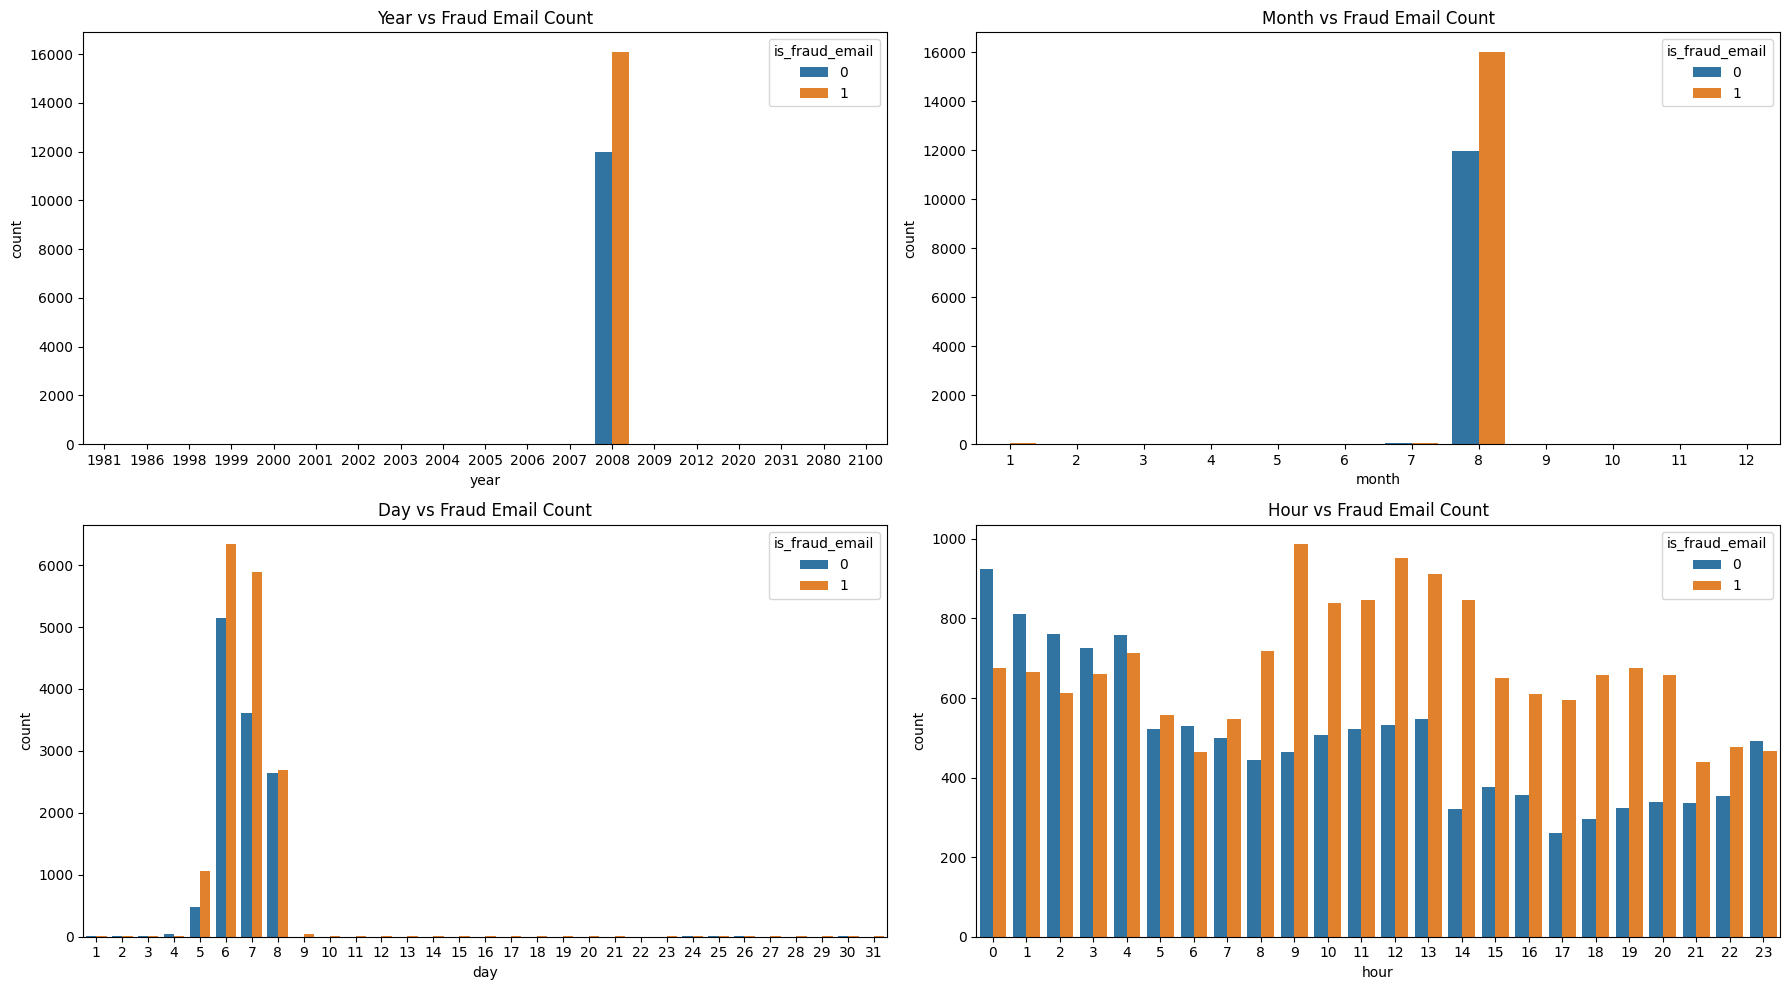

In [30]:
X_train_combined = X_train.copy()
X_train_combined['is_fraud_email'] = y_train

year_fraud_counts = X_train_combined.groupby(['year', 'is_fraud_email']).size().reset_index(name='count')
month_fraud_counts = X_train_combined.groupby(['month', 'is_fraud_email']).size().reset_index(name='count')
day_fraud_counts = X_train_combined.groupby(['day', 'is_fraud_email']).size().reset_index(name='count')
hour_fraud_counts = X_train_combined.groupby(['hour', 'is_fraud_email']).size().reset_index(name='count')

fig, axs = plt.subplots(2, 2, figsize=(18, 10))

sns.barplot(x='year', y='count', hue='is_fraud_email', data=year_fraud_counts, ax=axs[0, 0])
axs[0, 0].set_title('Year vs Fraud Email Count')

sns.barplot(x='month', y='count', hue='is_fraud_email', data=month_fraud_counts, ax=axs[0, 1])
axs[0, 1].set_title('Month vs Fraud Email Count')

sns.barplot(x='day', y='count', hue='is_fraud_email', data=day_fraud_counts, ax=axs[1, 0])
axs[1, 0].set_title('Day vs Fraud Email Count')

sns.barplot(x='hour', y='count', hue='is_fraud_email', data=hour_fraud_counts, ax=axs[1, 1])
axs[1, 1].set_title('Hour vs Fraud Email Count')

plt.tight_layout()
plt.show()

From the graphs above, we can see that there is a distinct difference in the distribution of `is_fraud_email` for `hour`, whereas the rest does not vary significantly in the distribution. Notably, there is a surge of emails in the year 2008, month of August and across the 5th to 8th of the month. 

## Feature Selection

In [31]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28228 entries, 8651 to 17799
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   date                       28228 non-null  datetime64[ns, UTC]
 1   subject                    28228 non-null  object             
 2   body                       28228 non-null  object             
 3   body_contains_url          28228 non-null  int64              
 4   sender_name                28228 non-null  object             
 5   sender_email               28228 non-null  object             
 6   receiver_email             28228 non-null  object             
 7   sender_domain              28228 non-null  object             
 8   receiver_domain            28228 non-null  object             
 9   year                       28228 non-null  int32              
 10  month                      28228 non-null  int32              
 11  day 

In [32]:
# following our analysis, we will be keeping: 
#   body_contains_url, sender_domain (one-hot encoded), hour, body (the embedded text)
# dropped receiver_domain as anyone could receive fraudulent emails?
# TODO: Decide on what to do about subject
X_train = X_train[["body_contains_url", "hour"]]
X_test = X_test[["body_contains_url", "hour"]]

X_train = X_train.reset_index(drop=True)
X_train_sender_domain_df = X_train_sender_domain_df.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_test_sender_domain_df = X_test_sender_domain_df.reset_index(drop=True)

# concatenate one-hot encoded sender_domain
X_train = pd.concat([X_train, X_train_sender_domain_df], axis=1)
X_test = pd.concat([X_test, X_test_sender_domain_df], axis=1)

In [33]:
# concatenate body: bag of words
X_train_bow_df = X_train_bow_df.reset_index(drop=True)
X_test_bow_df = X_test_bow_df.reset_index(drop=True)

X_train_body_bow = pd.concat([X_train, X_train_bow_df], axis=1)
X_test_body_bow = pd.concat([X_test, X_test_bow_df], axis=1)

In [34]:
# concatenate body: tfidf
X_train_tfidf_df = X_train_tfidf_df.reset_index(drop=True)
X_test_tfidf_df = X_test_tfidf_df.reset_index(drop=True)

X_train_body_tfidf = pd.concat([X_train, X_train_tfidf_df], axis=1)
X_test_body_tfidf = pd.concat([X_test, X_test_tfidf_df], axis=1)

In [35]:
# concatenate body: word2vec
X_train_word2vec_df = X_train_word2vec_df.reset_index(drop=True)
X_test_word2vec_df = X_test_word2vec_df.reset_index(drop=True)

X_train_body_word2vec = pd.concat([X_train, X_train_word2vec_df], axis=1)
X_test_body_word2vec = pd.concat([X_test, X_test_word2vec_df], axis=1)

In [36]:
# concatenate body: sentence transformers
X_train_st_df = X_train_st_df.reset_index(drop=True)
X_test_st_df = X_test_st_df.reset_index(drop=True)

X_train_body_st = pd.concat([X_train, X_train_st_df], axis=1)
X_test_body_st = pd.concat([X_test, X_test_st_df], axis=1)

## Modelling

In [37]:
def run_set(model_class, params=None):
    def run_model(X_train, X_test):
        model_params = params if params is not None else {}
        model = model_class(**model_params)  # Pass any necessary parameters here
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        return accuracy, report['Phishing Email']['f1-score'], report['Safe Email']['f1-score'] 

    results = []
    
    feature_sets = {
        "Bag of Words": (X_train_body_bow, X_test_body_bow),
        "TF-IDF": (X_train_body_tfidf, X_test_body_tfidf),
        "Word2Vec": (X_train_body_word2vec, X_test_body_word2vec),
        "Sentence Transformer": (X_train_body_st, X_test_body_st)
    }

    for feature_name, (X_train_feature, X_test_feature) in feature_sets.items():
        accuracy, spam_f1, non_spam_f1 = run_model(X_train_feature, X_test_feature)
        results.append({
            "Feature Set": feature_name,
            "Accuracy": accuracy,
            "Phishing Email F1 Score": spam_f1,
            "Safe Email F1 Score": non_spam_f1
        })

    return pd.DataFrame(results)

# Support Vector Machine

## Run Models Individually (SVM)

### Bag of Words

In [38]:
# # Step 1: Initialize the SVM classifier
# svm_model = SVC(kernel='linear', random_state=1)

# # Step 2: Train the SVM model
# svm_model.fit(X_train_bow, y_train)

# # Step 3: Make predictions on the test set
# y_pred = svm_model.predict(X_test_bow)

# # Step 4: Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))


### TF-IDF

In [39]:
# # Step 1: Initialize the SVM classifier
# svm_model = SVC(kernel='linear', random_state=1)

# # Step 2: Train the SVM model
# svm_model.fit(X_train_tfidf, y_train.values.ravel())  # Use ravel() to avoid issues with shape

# # Step 3: Make predictions on the test set
# y_pred = svm_model.predict(X_test_tfidf)

# # Step 4: Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

### Word2Vec

In [40]:
# # Step 1: Convert the lists of embeddings to numpy arrays
# X_train_word2vec = np.array(X_train_word2vec_embedding.tolist())
# X_test_word2vec = np.array(X_test_word2vec_embedding.tolist())

# # Step 2: Initialize the SVM classifier
# svm_model = SVC(kernel='linear', random_state=1)

# # Step 3: Train the SVM model
# svm_model.fit(X_train_word2vec, y_train)

# # Step 4: Make predictions on the test set
# y_pred = svm_model.predict(X_test_word2vec)

# # Step 7: Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))


### Sentence Transformer

In [41]:
# # Step 1: Initialize the SVM classifier
# svm_model = SVC(kernel='linear', random_state=1)

# # Step 2: Train the SVM model
# svm_model.fit(train_embeddings, y_train.values.ravel())  # Use ravel() to avoid issues with shape

# # Step 3: Make predictions on the test set
# y_pred = svm_model.predict(test_embeddings)

# # Step 4: Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))


## Support Vector Machine (SVM)

In [ ]:
svc_params = {'random_state': SEED}
svm = run_set(SVC, svc_params)
svm

/Users/szeyinglim/Desktop/BT4012/Fraud-Email/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Random Forest

## Run Models Individually (SVM)

### Bag of Words

In [37]:
# # Step 1: Train the Random Forest model
# rf_model = RandomForestClassifier(random_state=1)  # You can adjust hyperparameters as needed
# rf_model.fit(X_train_bow, y_train)

# # Step 2: Make predictions
# y_pred = rf_model.predict(X_test_bow)

# # Step 3: Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# # Print results
# print(f"Accuracy: {accuracy:.4f}")
# print("Classification Report:\n", report)

c:\Users\jinge\Desktop\BT4012\Fraud-Email\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.9718
Classification Report:
                 precision    recall  f1-score   support

Phishing Email       0.97      0.96      0.96      1311
    Safe Email       0.97      0.98      0.98      2197

      accuracy                           0.97      3508
     macro avg       0.97      0.97      0.97      3508
  weighted avg       0.97      0.97      0.97      3508



### TF-IDF

In [38]:
# # Step 1: Train the Random Forest model
# rf_model = RandomForestClassifier(random_state=1)  # You can adjust hyperparameters as needed
# rf_model.fit(X_train_tfidf, y_train)

# # Step 2: Make predictions
# y_pred = rf_model.predict(X_test_tfidf)

# # Step 3: Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# # Print results
# print(f"Accuracy: {accuracy:.4f}")
# print("Classification Report:\n", report)

c:\Users\jinge\Desktop\BT4012\Fraud-Email\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.9729
Classification Report:
                 precision    recall  f1-score   support

Phishing Email       0.97      0.95      0.96      1311
    Safe Email       0.97      0.98      0.98      2197

      accuracy                           0.97      3508
     macro avg       0.97      0.97      0.97      3508
  weighted avg       0.97      0.97      0.97      3508



### Word2Vec

In [39]:
# # Step 1: Train the Random Forest model
# rf_model = RandomForestClassifier(random_state=1)  # You can adjust hyperparameters as needed
# rf_model.fit(X_train_word2vec, y_train)

# # Step 2: Make predictions
# y_pred = rf_model.predict(X_test_word2vec)

# # Step 3: Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# # Print results
# print(f"Accuracy: {accuracy:.4f}")
# print("Classification Report:\n", report)

c:\Users\jinge\Desktop\BT4012\Fraud-Email\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.9624
Classification Report:
                 precision    recall  f1-score   support

Phishing Email       0.96      0.94      0.95      1311
    Safe Email       0.97      0.97      0.97      2197

      accuracy                           0.96      3508
     macro avg       0.96      0.96      0.96      3508
  weighted avg       0.96      0.96      0.96      3508



### Sentence Transformer

In [40]:
# # Step 1: Train the Random Forest model
# rf_model = RandomForestClassifier(random_state=1)  # You can adjust hyperparameters as needed
# rf_model.fit(train_embeddings, y_train)

# # Step 2: Make predictions
# y_pred = rf_model.predict(test_embeddings)

# # Step 3: Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# # Print results
# print(f"Accuracy: {accuracy:.4f}")
# print("Classification Report:\n", report)

c:\Users\jinge\Desktop\BT4012\Fraud-Email\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.9438
Classification Report:
                 precision    recall  f1-score   support

Phishing Email       0.97      0.88      0.92      1311
    Safe Email       0.93      0.98      0.96      2197

      accuracy                           0.94      3508
     macro avg       0.95      0.93      0.94      3508
  weighted avg       0.95      0.94      0.94      3508



## Run all (Random Forest)

In [84]:
from sklearn.ensemble import RandomForestClassifier

# Step 1: Collect results
results = []

# Step 2: Define a function to train Random Forest and evaluate
def run_random_forest(X_train, X_test, y_train, y_test, feature_name):
    rf_model = RandomForestClassifier(random_state=1)  # You can adjust hyperparameters as needed
    rf_model.fit(X_train, y_train.values.ravel())
    y_pred = rf_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    return accuracy, report['1']['f1-score'], report['0']['f1-score']  # Adjust 'Phishing Email'/'Safe Email' according to your labels

# Run Random Forest for each feature set
feature_sets = {
    "Bag of Words": (X_train_bow, X_test_bow),
    "TF-IDF": (X_train_tfidf, X_test_tfidf),
    "Word2Vec": (X_train_word2vec, X_test_word2vec),
    "Sentence Transformer": (train_embeddings, test_embeddings)
}

for feature_name, (X_train_feature, X_test_feature) in feature_sets.items():
    accuracy, phishing_f1, safe_f1 = run_random_forest(X_train_feature, X_test_feature, y_train, y_test, feature_name)
    results.append({
        "Feature Set": feature_name,
        "Accuracy": accuracy,
        "Phishing Email F1 Score": phishing_f1,
        "Safe Email F1 Score": safe_f1
    })

# Step 3: Create a DataFrame to represent the results
results_df = pd.DataFrame(results)

# Step 4: Display the results
print(results_df)


            Feature Set  Accuracy  Phishing Email F1 Score  \
0          Bag of Words  0.970353                 0.959969   
1                TF-IDF  0.972064                 0.962074   
2              Word2Vec  0.962942                 0.950038   
3  Sentence Transformer  0.941277                 0.917069   

   Safe Email F1 Score  
0             0.976460  
1             0.977888  
2             0.970548  
3             0.954545  


In [85]:
results_df

,Feature Set,Accuracy,Phishing Email F1 Score,Safe Email F1 Score
0,Bag of Words,0.970353,0.959969,0.976460
1,TF-IDF,0.972064,0.962074,0.977888
2,Word2Vec,0.962942,0.950038,0.970548
3,Sentence Transformer,0.941277,0.917069,0.954545


# XGBoost

## Run Models Individually (XGBoost)

In [72]:
from xgboost import XGBClassifier

### Bag of Words

In [78]:
# Step 1: Initialize the XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder = True, eval_metric='mlogloss', random_state=1)

# Step 2: Train the model
xgb_model.fit(X_train_bow, y_train)

# # Step 3: Make predictions on the test set
y_pred = xgb_model.predict(X_test_bow)

# # Step 4: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['Phishing Email' 'Safe Email']

### TF-IDF

In [73]:
# Step 1: Initialize the XGBoost classifier
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=1)

# Step 2: Train the model
xgb_model.fit(X_train_tfidf, y_train)

# # Step 3: Make predictions on the test set
y_pred = xgb_model.predict(X_test_tfidf)

# # Step 4: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9632269099201825
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      2197
           1       0.95      0.95      0.95      1311

    accuracy                           0.96      3508
   macro avg       0.96      0.96      0.96      3508
weighted avg       0.96      0.96      0.96      3508



### Word2Vec

In [74]:
# Step 1: Initialize the XGBoost classifier
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=1)

# Step 2: Train the model
xgb_model.fit(X_train_word2vec, y_train)

# # Step 3: Make predictions on the test set
y_pred = xgb_model.predict(X_test_word2vec)

# # Step 4: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9692132269099202
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      2197
           1       0.96      0.96      0.96      1311

    accuracy                           0.97      3508
   macro avg       0.97      0.97      0.97      3508
weighted avg       0.97      0.97      0.97      3508



### Sentence Transformer

In [75]:
# Step 1: Initialize the XGBoost classifier
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=1)

# Step 2: Train the model
xgb_model.fit(train_embeddings, y_train)

# # Step 3: Make predictions on the test set
y_pred = xgb_model.predict(test_embeddings)

# # Step 4: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9620866590649944
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      2197
           1       0.96      0.94      0.95      1311

    accuracy                           0.96      3508
   macro avg       0.96      0.96      0.96      3508
weighted avg       0.96      0.96      0.96      3508



## Run all (XGBoost)

In [81]:
from xgboost import XGBClassifier

# Step 1: Collect results
results = []

# Step 2: Define a function to train XGBoost and evaluate
def run_xgboost(X_train, X_test, y_train, y_test, feature_name):
    xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=1)
    xgb_model.fit(X_train, y_train.values.ravel())
    y_pred = xgb_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    return accuracy, report['1']['f1-score'], report['0']['f1-score']  # Adjust 'Phishing Email'/'Safe Email' according to your labels

# Run XGBoost for each feature set
feature_sets = {
    "Bag of Words": (X_train_bow, X_test_bow),
    "TF-IDF": (X_train_tfidf, X_test_tfidf),
    "Word2Vec": (X_train_word2vec, X_test_word2vec),
    "Sentence Transformer": (train_embeddings, test_embeddings)
}

for feature_name, (X_train_feature, X_test_feature) in feature_sets.items():
    accuracy, phishing_f1, safe_f1 = run_xgboost(X_train_feature, X_test_feature, y_train, y_test, feature_name)
    results.append({
        "Feature Set": feature_name,
        "Accuracy": accuracy,
        "Phishing Email F1 Score": phishing_f1,
        "Safe Email F1 Score": safe_f1
    })

# Step 3: Create a DataFrame to represent the results
results_df = pd.DataFrame(results)

# Step 4: Display the results
print(results_df)


            Feature Set  Accuracy  Phishing Email F1 Score  \
0          Bag of Words  0.968928                 0.958696   
1                TF-IDF  0.963227                 0.951006   
2              Word2Vec  0.969213                 0.958747   
3  Sentence Transformer  0.962087                 0.948668   

   Safe Email F1 Score  
0             0.975097  
1             0.970568  
2             0.975443  
3             0.969944  


In [82]:
results_df

,Feature Set,Accuracy,Phishing Email F1 Score,Safe Email F1 Score
0,Bag of Words,0.968928,0.958696,0.975097
1,TF-IDF,0.963227,0.951006,0.970568
2,Word2Vec,0.969213,0.958747,0.975443
3,Sentence Transformer,0.962087,0.948668,0.969944
